In [1]:
import tensorflow as tf
print(f"tf.__version__: {tf.__version__}")
if tf.test.gpu_device_name(): 
    print(f"Default GPU Device:{tf.test.gpu_device_name()}")
else:
    print("Please install GPU version of TF")
from os import getcwd
import os.path
from os import listdir
import numpy as np
import pandas as pd
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler, StandardScaler

tf.__version__: 2.4.1
Please install GPU version of TF



Bad key "text.kerning_factor" on line 4 in
/data01/home/baroncelli/.conda/envs/bphd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
datapath = Path("/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output")
print(datapath)
assert datapath.is_dir() == True

/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output


In [3]:
currentdir = getcwd()
currentdir

'/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis'

In [4]:
outdir = Path(currentdir).joinpath("notebook_lstm_output")
outdir

PosixPath('/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_lstm_output')

In [5]:
SAMPLE_SIZE = 180

In [6]:
dataDir = datapath.joinpath("run0406_ID000126_OK_bkg_only","csv")
files = [  pd.read_csv(dataDir.joinpath(f), header=0) for f in listdir(dataDir) if dataDir.joinpath(f).is_file()]
# dataframe = pd.concat(li, axis=0, ignore_index=True)
# numberOfSamples = int(dataframe.shape[0]/SAMPLE_SIZE)
# dataframe = pd.DataFrame(dataframe["COUNTS"].values.reshape(numberOfSamples, SAMPLE_SIZE))

files = [  dataDir.joinpath(f) for f in listdir(dataDir) if dataDir.joinpath(f).is_file()]
dataframe = pd.read_csv(files[0], header=0)

In [7]:
dataframe.shape

(180, 5)

In [8]:
dataframe

,VALMIN,VALMAX,VALCENTER,COUNTS,ERROR
0,0,10,5.0,293,17.1172
1,10,20,15.0,235,15.3297
2,20,30,25.0,279,16.7033
3,30,40,35.0,224,14.9666
4,40,50,45.0,277,16.6433
...,...,...,...,...,...
175,1750,1760,1755.0,249,15.7797
176,1760,1770,1765.0,244,15.6205
177,1770,1780,1775.0,274,16.5529
178,1780,1790,1785.0,248,15.7480


In [9]:
n = len(dataframe)
train_df = dataframe[0:int(n*0.7)]
val_df = dataframe[int(n*0.7):int(n*0.9)]
test_df = dataframe[int(n*0.9):]

num_features = dataframe.shape[1]
num_features

5

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
train_df.head()

,VALMIN,VALMAX,VALCENTER,COUNTS,ERROR
0,-1.711363,-1.711363,-1.711363,1.992335,1.937933
1,-1.683760,-1.683760,-1.683760,-1.664483,-1.682459
2,-1.656157,-1.656157,-1.656157,1.109655,1.099622
3,-1.628555,-1.628555,-1.628555,-2.358017,-2.417880
4,-1.600952,-1.600952,-1.600952,0.983558,0.978099


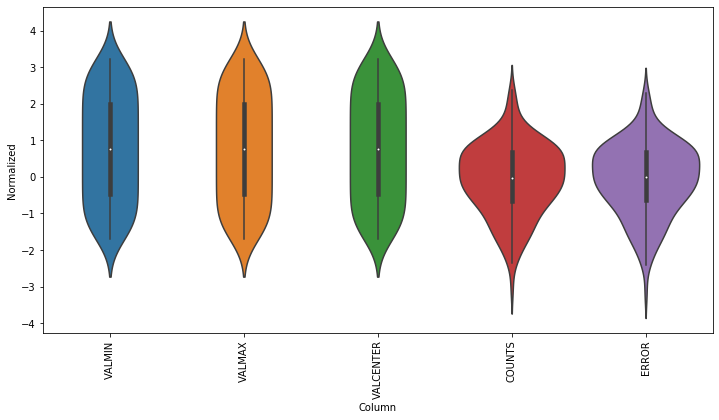

In [12]:
df_std = (dataframe - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dataframe.keys(), rotation=90)

In [13]:
def drop_columns(df, columns):
    for c in columns:
        df.drop(c, inplace=True, axis=1)


In [14]:
train_df["CLASS"] = 0
val_df["CLASS"] = 0
test_df["CLASS"] = 0

In [15]:
drop_columns(train_df, ["VALMIN", "VALMAX", "VALCENTER"])
drop_columns(val_df, ["VALMIN", "VALMAX", "VALCENTER"])
drop_columns(test_df, ["VALMIN", "VALMAX", "VALCENTER"])

In [16]:
train_df

,COUNTS,ERROR,CLASS
0,1.992335,1.937933,0
1,-1.664483,-1.682459,0
2,1.109655,1.099622,0
3,-2.358017,-2.417880,0
4,0.983558,0.978099,0
...,...,...,...
120,0.731364,0.733836,0
121,-0.151317,-0.135463,0
122,-1.412288,-1.419361,0
123,1.235752,1.220741,0


In [17]:
data = np.array(train_df, dtype=np.float32)

In [18]:
data

array([[ 1.9923351 ,  1.937933  ,  0.        ],
       [-1.6644825 , -1.6824594 ,  0.        ],
       [ 1.109655  ,  1.0996222 ,  0.        ],
       [-2.358017  , -2.41788   ,  0.        ],
       [ 0.9835578 ,  0.9780986 ,  0.        ],
       [-0.34046233, -0.3248376 ,  0.        ],
       [ 0.66831493,  0.6724666 ,  0.        ],
       [-0.5926567 , -0.57902455,  0.        ],
       [-1.0339967 , -1.0286621 ,  0.        ],
       [-0.08826801, -0.07267601,  0.        ],
       [-1.2231425 , -1.223505  ,  0.        ],
       [ 0.73136353,  0.733836  ,  0.        ],
       [-0.02521943, -0.00988878,  0.        ],
       [ 1.0466064 ,  1.0388604 ,  0.        ],
       [-0.7187538 , -0.706827  ,  0.        ],
       [ 0.73136353,  0.733836  ,  0.        ],
       [ 0.35307205,  0.363999  ,  0.        ],
       [ 0.6052664 ,  0.6110971 ,  0.        ],
       [-0.5926567 , -0.57902455,  0.        ],
       [ 0.7944121 ,  0.79500294,  0.        ],
       [-0.1513166 , -0.13546324,  0.   

In [42]:
class WindowGenerator():

    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None, label_is_feature=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_is_feature = label_is_feature
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
            if label_is_feature is None:
                self.label_is_feature = [True for l in label_columns]
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        #print(f"input_width: {self.input_width}")
        #print(f"label_width: {self.label_width}")
        #print(f"input_slice: {self.input_slice}")
        #print(f"input_indices: {self.input_indices}") 
        #print(f"label_start: {self.label_start}")
        #print(f"labels_slice: {self.labels_slice}")
        #print(f"label_indices: {self.label_indices}")

                          
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, data):
        #print("split window called!")
        #print(f"data: {data}")
        #print(f"data.shape: {data.shape}")
        #print(f"input_slice: {self.input_slice}")
        #print(f"labels_slice: {self.labels_slice}"


        labels = data[:, self.labels_slice, :]

        # THE INPUT SLICE MUST DELETE THE LABEL COLUMNS IF THEY ARE NOT FEATURES
        # FOR NOW, I REMOVE THE CLASS COLUMN MANUALLY

        inputs = data[:, self.input_slice, :2]
        
        
        #print(f"inputs: {inputs}")
        #print(f"labels: {labels}")
        #print(f"label_columns: {self.label_columns}")
        #print(f"column_indices[class]: {self.column_indices['CLASS']}")

        
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        #print("labels: ",labels)
                
        
        #print(inputs.shape)
        #print(labels.shape)

                    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        
        labels.set_shape([None, None, 1])

        
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(  data=data,
                                                                    targets=None,
                                                                    sequence_length=self.total_window_size,
                                                                    sequence_stride=1,
                                                                    shuffle=True,
                                                                    batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    def set_example(self, example_inputs, example_labels):
        self.example = example_inputs, example_labels

        
    def remove_class_columns_if_not_features(self, df):

        for i, label in enumerate(self.label_columns):
            if not self.label_is_feature[i]:
                df.drop(label, axis=1, inplace=True)        
        
        # print("df: ",df)
        return df
        
    @property
    def train(self):
        #print(self.train_df)
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        # print(f"result: {result}")

        return result


In [43]:
data_window = WindowGenerator(input_width=10, 
                             label_width=1, 
                             shift=0, 
                             train_df=train_df, 
                             test_df=test_df, 
                             val_df=val_df, 
                             label_columns=["CLASS"], 
                             label_is_feature=[False])



In [44]:
for example_inputs, example_labels in data_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    print("example_inputs: ",example_inputs[0])
    print("example_labels: ",example_labels[0])

Inputs shape (batch, time, features): (32, 10, 2)
Labels shape (batch, time, features): (32, 1, 1)
example_inputs:  tf.Tensor(
[[ 1.4248979   1.4014059 ]
 [-1.0970453  -1.0934747 ]
 [ 0.29002348  0.30202195]
 [-0.6557052  -0.64282453]
 [ 0.10087772  0.11528058]
 [-0.84485096 -0.83523697]
 [ 0.41612062  0.42597607]
 [ 0.66831493  0.6724666 ]
 [ 0.29002348  0.30202195]
 [-2.1688712  -2.2155433 ]], shape=(10, 2), dtype=float32)
example_labels:  tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


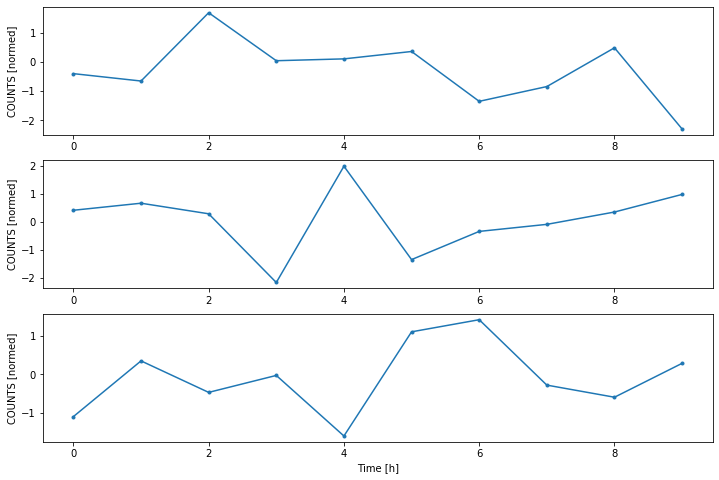

In [45]:
def plot(self, model=None, plot_col='', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], dgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


    return inputs, labels


WindowGenerator.plot=plot

_ = data_window.plot(plot_col="COUNTS")

In [46]:
for example_inputs, example_labels in data_window.train.take(5):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 2)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 10, 2)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 10, 2)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (20, 10, 2)
Labels shape (batch, time, features): (20, 1, 1)


In [50]:
example_inputs = data_window.train.take(1)
example_inputs

<TakeDataset shapes: ((None, 10, 2), (None, None, 1)), types: (tf.float32, tf.float32)>

In [60]:
data_window.example[0].shape

TensorShape([32, 10, 2])

In [61]:
input_shape=(data_window.example[0].shape[1], data_window.example[0].shape[2])

In [62]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(32, input_shape=input_shape))
modelLSTM.add(Dropout(rate=0.3))
modelLSTM.add(RepeatVector(input_shape[0]))
modelLSTM.add(LSTM(32, return_sequences=True))
modelLSTM.add(Dropout(rate=0.3))
modelLSTM.add(TimeDistributed(Dense(input_shape[1])))

modelLSTM.compile(optimizer='adam', loss='mae')
modelLSTM.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 2)             66        
Total params: 12,866
Trainable params: 12,866
Non-trainable params: 0
__________________________________________________

In [67]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    save_weights_cb = keras.callbacks.ModelCheckpoint(filepath=str(checkpoint_path_lstm), save_weights_only=True, verbose=1)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(data_window.train, epochs=MAX_EPOCHS,
                        # validation_data=window.val,
                        batch_size=32,
                        verbose=1,
                        callbacks=[save_weights_cb, early_stopping_cb]
                       )
    

    return history

In [68]:
checkpoint_path_lstm = Path("./lstm_exp3/training_lstm/cp.ckpt")
checkpoint_path_lstm.mkdir(exist_ok=True, parents=True)

In [69]:
epochs=20

In [70]:
history = compile_and_fit(modelLSTM, data_window)

Epoch 1/20
4/4 [==============================] - 3s 16ms/step - loss: 3.2043e-04 - mean_absolute_error: 0.0124

Epoch 00001: saving model to lstm_exp3/training_lstm/cp.ckpt
Epoch 2/20
4/4 [==============================] - 0s 14ms/step - loss: 2.1909e-04 - mean_absolute_error: 0.0102

Epoch 00002: saving model to lstm_exp3/training_lstm/cp.ckpt
Epoch 3/20
4/4 [==============================] - 0s 13ms/step - loss: 2.0001e-04 - mean_absolute_error: 0.0093

Epoch 00003: saving model to lstm_exp3/training_lstm/cp.ckpt
Epoch 4/20
4/4 [==============================] - 0s 12ms/step - loss: 1.8157e-04 - mean_absolute_error: 0.0088

Epoch 00004: saving model to lstm_exp3/training_lstm/cp.ckpt
Epoch 5/20
4/4 [==============================] - 0s 11ms/step - loss: 1.2855e-04 - mean_absolute_error: 0.0075

Epoch 00005: saving model to lstm_exp3/training_lstm/cp.ckpt
Epoch 6/20
4/4 [==============================] - 0s 12ms/step - loss: 1.1421e-04 - mean_absolute_error: 0.0073

Epoch 00006: savi

KeyError: 'val_loss'

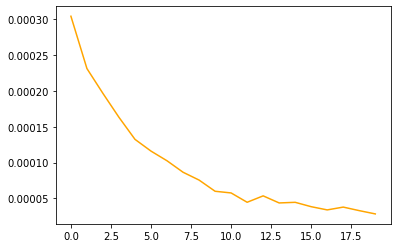

In [73]:
plt.plot(history.history["loss"], label="LSTM Training Loss", color="orange")
#plt.plot(history.history["val_loss"], label="LSTM Validation Loss", color="orange", linestyle="--")



In [75]:
lstm_predictions_on_training = modelLSTM.predict(data_window.test)

In [80]:
lstm_predictions_on_training

array([[[-6.84956438e-04, -9.31966817e-04],
        [-8.94839177e-04, -7.06436753e-04],
        [-8.90128082e-04, -1.74839137e-04],
        [-7.93030718e-04,  4.49235522e-04],
        [-6.69015339e-04,  1.05565507e-03],
        [-5.50184632e-04,  1.59404753e-03],
        [-4.49853687e-04,  2.04729335e-03],
        [-3.71357164e-04,  2.41573597e-03],
        [-3.13225872e-04,  2.70798663e-03],
        [-2.72064208e-04,  2.93573854e-03]],

       [[-2.43866161e-04,  2.00130016e-04],
        [-3.09609546e-04,  5.72781661e-04],
        [-3.02540575e-04,  7.76556670e-04],
        [-2.60578323e-04,  8.84577283e-04],
        [-2.06070472e-04,  9.39952093e-04],
        [-1.51144792e-04,  9.67535889e-04],
        [-1.01588186e-04,  9.81238671e-04],
        [-5.94944977e-05,  9.88531858e-04],
        [-2.49771219e-05,  9.93194408e-04],
        [ 2.78094740e-06,  9.96968942e-04]],

       [[-4.94097709e-04, -1.66315265e-04],
        [-6.47596316e-04,  1.65196339e-04],
        [-6.47580484e-04,  4

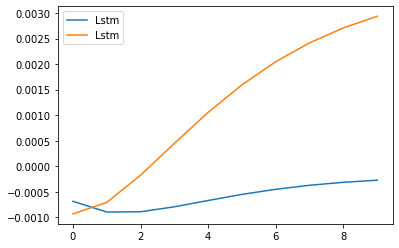

In [79]:
plt.plot(lstm_predictions_on_training[0], label="Lstm")
plt.legend()
plt.show()